In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import pearsonr

In [2]:
dirpath = "../results/results/predictions/"

cache_files = ["cache/knn_pred_test_cache.csv", 
               "cache/catboost_density_pred_test_cache.csv", 
               "cache/nf_pred_test_cache.csv"]

ssdrnd_files = ["pools/knn_pred_test_ssd_random.csv", 
                "pools/catboost_density_pred_test_ssd_random.csv", 
                "pools/nf_pred_test_ssd_random.csv"]

ssdseq_files = ["pools/knn_pred_test_ssd_sequential.csv", 
                "pools/catboost_density_pred_test_ssd_sequential.csv", 
                "pools/nf_pred_test_ssd_sequential.csv"]

hddseq_files = ["pools/knn_pred_test_hdd_sequential.csv", 
                "pools/catboost_density_pred_test_hdd_sequential.csv", 
                "pools/nf_pred_test_hdd_sequential.csv"]

batches = [cache_files, ssdrnd_files, ssdseq_files, hddseq_files]

In [3]:
df = pd.read_csv(dirpath+ssdrnd_files[0])
df.head(3)

,block_size,n_jobs,iodepth,read_fraction,load_type,io_type,raid,n_disks,gen_iops,gen_lat,id,iops,lat
0,32,10,30,80,random,read,4+2,8,227442,736061.88,hse-07172022-131526-z97611,254270,954386.9
1,32,10,30,80,random,read,4+2,8,245386,696138.38,hse-07172022-131526-z97611,261943,925619.1
2,32,10,30,80,random,read,4+2,8,246454,693477.00,hse-07172022-131526-z97611,252774,969505.3


In [4]:
def get_run(df, run_id, io_type='read'):
    io = df['io_type'].values.astype(str)
    ids = df['id'].values
    if io_type == 'read':
        sel = (io == 'read') | (io == '0')
    elif io_type == 'write':
        sel = (io == 'write') | (io == '1')
    sel = sel & (ids == run_id)
    return df[sel]

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

def remove_outliers(x, y, q=0.02):
    # ee = EllipticEnvelope(contamination=q)
    ee = IsolationForest(contamination=q)
    xy = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1)
    lab = ee.fit_predict(xy)
    # print(lab.sum()/len(lab))
    xy = xy[lab==1]
    return xy[:, 0], xy[:, 1]

In [5]:
def get_plots(batch, run_id, io_type='read', t='ms', adir="plots/"):
    
    names = ["KNN", "CatBoost", "NF"]
    
    x_min = 10**10
    x_max = 0
    
    y_min = 10**10
    y_max = 0
    
    plt.figure(figsize=(12, 4))
    for i, afile in enumerate(batch):
        
        df = pd.read_csv(dirpath+afile)
        df_run = get_run(df, run_id, io_type)
        if len(df_run) == 0:
            return
        
        if t == 'ms':
            scale = 10**9
        elif t == r'$\mu$s':
            scale = 10**6
        
        iops = df_run['iops'].values / 1000
        lat = df_run['lat'].values / scale
        gen_iops = df_run['gen_iops'].values / 1000
        gen_lat = df_run['gen_lat'].values / scale
        
        iops, lat = remove_outliers(iops, lat)
        gen_iops, gen_lat = remove_outliers(gen_iops, gen_lat)
        
        x_min = min(x_min, iops.min(), gen_iops.min())
        x_max = max(x_max, iops.max(), gen_iops.max())
        y_min = min(y_min, lat.min(), gen_lat.min())
        y_max = max(y_max, lat.max(), gen_lat.max())
        
        if i == 0:
            ax = plt.subplot(1, 3, i+1)
        else:
            ax = plt.subplot(1, 3, i+1, sharey=ax, sharex=ax)
        plt.scatter(iops, lat, color='C0', label='Observations')
        plt.scatter(gen_iops, gen_lat, color='C3', label='Predictions')
        plt.title(names[i], size=12)
        plt.xlabel(r"IOPS, $10^3$", size=12)
        plt.ylabel("Latency, "+t, size=12)
        plt.xticks(size=12)
        plt.yticks(size=12)
        plt.legend(fontsize=12)
    
    dx = x_max - x_min
    dy = y_max - y_min
    ax.set_xlim(x_min-0.05*dx, x_max+0.05*dx)
    ax.set_ylim(y_min-0.05*dy, y_max+0.05*dy)
    plt.tight_layout()
    if adir is not None:
        plt.savefig(adir+io_type+"-"+run_id+".pdf", format='pdf')
    #plt.show()

In [6]:
abatch = batches[0]
df = pd.read_csv(dirpath+abatch[1])
ids = np.unique(df['id'].values)

for i in range(len(ids)):
    #print(ids[i])
    get_plots(abatch, ids[i], 'read', r'$\mu$s', "plots/cache/")
    plt.close()
    get_plots(abatch, ids[i], 'write', r'$\mu$s', "plots/cache/")
    plt.close()

In [7]:
abatch = batches[1]
df = pd.read_csv(dirpath+abatch[1])
ids = np.unique(df['id'].values)

for i in range(len(ids)):
    #print(ids[i])
    get_plots(abatch, ids[i], 'read', r'$\mu$s', "plots/ssdrnd/")
    plt.close()
    get_plots(abatch, ids[i], 'write', r'$\mu$s', "plots/ssdrnd/")
    plt.close()

In [8]:
abatch = batches[2]
df = pd.read_csv(dirpath+abatch[1])
ids = np.unique(df['id'].values)

for i in range(len(ids)):
    #print(ids[i])
    get_plots(abatch, ids[i], 'read', r'$\mu$s', "plots/ssdseq/")
    plt.close()
    get_plots(abatch, ids[i], 'write', r'$\mu$s', "plots/ssdseq/")
    plt.close()

In [9]:
abatch = batches[3]
df = pd.read_csv(dirpath+abatch[1])
ids = np.unique(df['id'].values)

for i in range(len(ids)):
    #print(ids[i])
    get_plots(abatch, ids[i], 'read', r'ms', "plots/hddseq/")
    plt.close()
    get_plots(abatch, ids[i], 'write', r'ms', "plots/hddseq/")
    plt.close()

# Little's law

In [10]:
def get_little_law(afile, is_obs=False):
    df = pd.read_csv(afile)
    ids = np.unique(df['id'].values)
    y_pred = []
    y_true = []
    for i in range(len(ids)):
        iol_pred = 0
        iol_true = 0
        for io_type in ['read', 'write']:
            adf = get_run(df, ids[i], io_type=io_type)
            if len(adf) != 0:
                if is_obs:
                    iol = (adf['iops'].values * adf['lat'].values / 10**9).mean()
                else:
                    iol = (adf['gen_iops'].values * adf['gen_lat'].values / 10**9).mean()
                iol_pred += iol
                iol_true = (adf['iodepth'].values * adf['n_jobs'].values).mean()
        y_pred.append(iol_pred)
        y_true.append(iol_true)
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return y_true, y_pred 

cache/knn_pred_test_cache.csv
cache/knn_pred_test_cache.csv
cache/catboost_density_pred_test_cache.csv
cache/nf_pred_test_cache.csv
pools/knn_pred_test_ssd_random.csv
pools/knn_pred_test_ssd_random.csv
pools/catboost_density_pred_test_ssd_random.csv
pools/nf_pred_test_ssd_random.csv
pools/knn_pred_test_ssd_sequential.csv
pools/knn_pred_test_ssd_sequential.csv
pools/catboost_density_pred_test_ssd_sequential.csv
pools/nf_pred_test_ssd_sequential.csv
pools/knn_pred_test_hdd_sequential.csv
pools/knn_pred_test_hdd_sequential.csv
pools/catboost_density_pred_test_hdd_sequential.csv
pools/nf_pred_test_hdd_sequential.csv


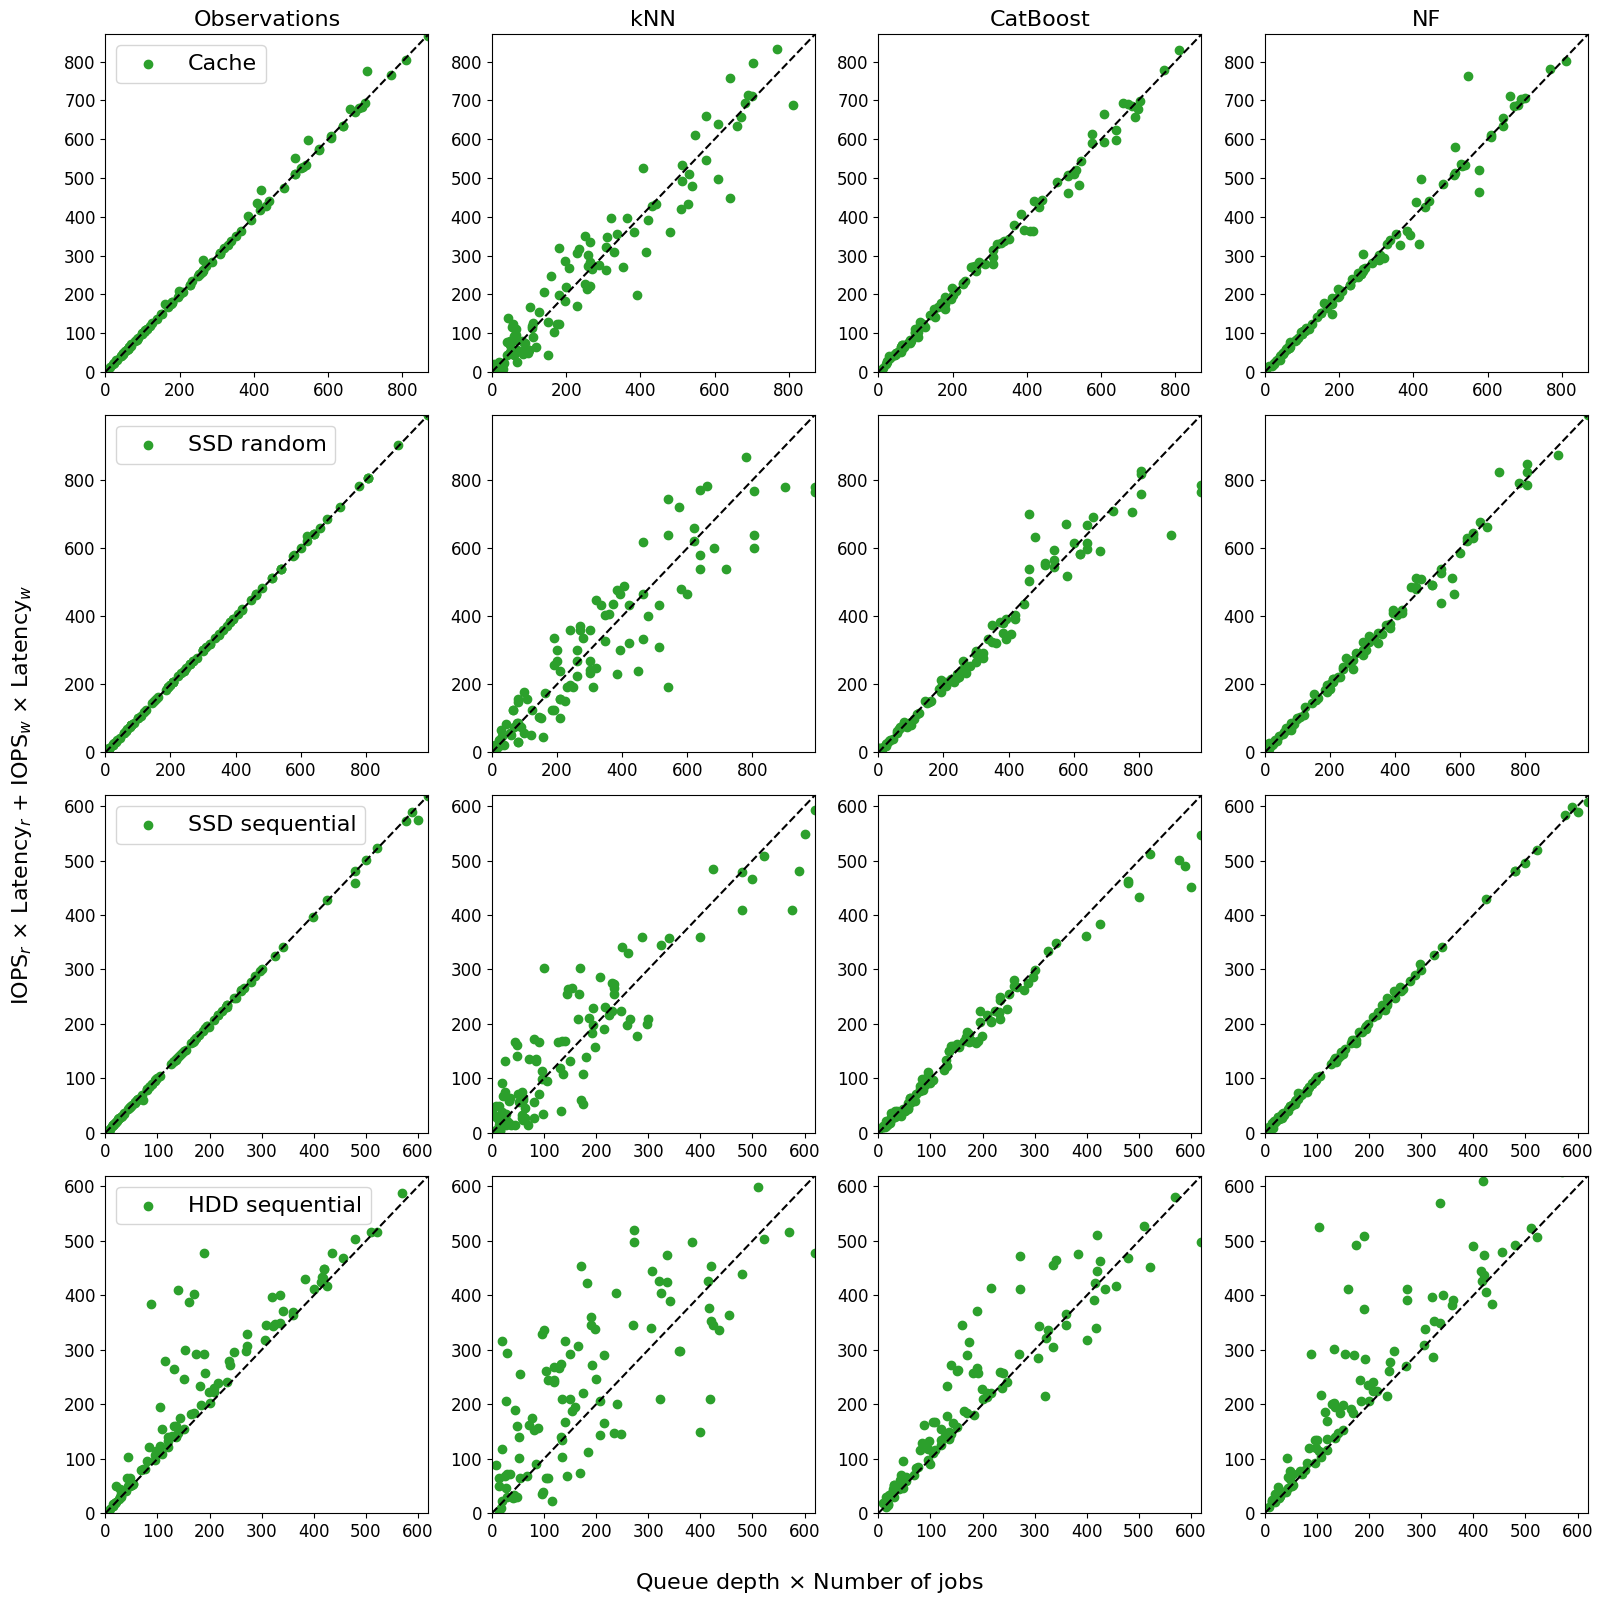

In [11]:
fig = plt.figure(figsize=(16, 16))

titles = ['Observations', 'kNN', 'CatBoost', 'NF']
labels = ['Cache', 'SSD random', 'SSD sequential', 'HDD sequential']

for k, abatch in enumerate(batches):
    abatch = [abatch[0]] + abatch
    for i, afile in enumerate(abatch):
        print(afile)
        is_obs = False
        if i == 0: is_obs=True
        y_true, y_pred = get_little_law(dirpath+afile, is_obs)
        
        plt.subplot(4, 4, k*4+i+1)
        if i == 0:
            plt.scatter(y_true, y_pred, color='C2', label=labels[k])
        else:
            plt.scatter(y_true, y_pred, color='C2')
        plt.plot([0, y_true.max()], [0, y_true.max()], color='0', linestyle='--')
        plt.xlim(0, y_true.max())
        plt.ylim(0, y_true.max())
        plt.xticks(size=12)
        plt.yticks(size=12)
        #plt.grid(color='0.5')
        if k == 0:
            plt.title(titles[i], size=16)
        if i == 0:
            plt.legend(loc='best', fontsize=16)
        
fig.supxlabel(r"Queue depth $\times$ Number of jobs", size=16, y=0.)
fig.supylabel(r"IOPS$_r$ $\times$ Latency$_r$ + IOPS$_w$ $\times$ Latency$_w$", size=16, x=0.)
plt.tight_layout()
plt.savefig("plots/little_law.pdf", format='pdf')
plt.show()

In [12]:
from sklearn.utils import resample

def _bootstrap_metric(x, y, n_iters=1000):
    scores = []
    q = np.quantile(y, 0.98)
    x = x[y<=q]
    y = y[y<=q]
    for i in range(n_iters):
        x_boot, y_boot = resample(x, y, random_state=i+1)
        r = pearsonr(x_boot, y_boot)[0]
        scores.append(r)
    scores = np.array(scores)
    return scores.mean(axis=0), scores.std(axis=0)

In [13]:
titles = ['Observations', 'kNN', 'CatBoost', 'NF']

res = pd.DataFrame(np.zeros((4, 4)), columns=titles)

for k, abatch in enumerate(batches):
    abatch = [abatch[0]] + abatch
    for i, afile in enumerate(abatch):
        print(afile)
        is_obs = False
        if i == 0: is_obs=True
        y_true, y_pred = get_little_law(dirpath+afile, is_obs)
        mu, sigma = _bootstrap_metric(y_true, y_pred)
        res.iloc[k, i] = "(%.5f, %.5f)" % (mu, sigma)
        
res

cache/knn_pred_test_cache.csv
cache/knn_pred_test_cache.csv
cache/catboost_density_pred_test_cache.csv
cache/nf_pred_test_cache.csv
pools/knn_pred_test_ssd_random.csv
pools/knn_pred_test_ssd_random.csv
pools/catboost_density_pred_test_ssd_random.csv
pools/nf_pred_test_ssd_random.csv
pools/knn_pred_test_ssd_sequential.csv
pools/knn_pred_test_ssd_sequential.csv
pools/catboost_density_pred_test_ssd_sequential.csv
pools/nf_pred_test_ssd_sequential.csv
pools/knn_pred_test_hdd_sequential.csv
pools/knn_pred_test_hdd_sequential.csv
pools/catboost_density_pred_test_hdd_sequential.csv
pools/nf_pred_test_hdd_sequential.csv


,Observations,kNN,CatBoost,NF
0,"(0.99892, 0.00042)","(0.95556, 0.00897)","(0.99649, 0.00081)","(0.98984, 0.00501)"
1,"(0.99997, 0.00002)","(0.91701, 0.01627)","(0.97427, 0.00841)","(0.99436, 0.00199)"
2,"(0.99982, 0.00011)","(0.88508, 0.02566)","(0.98958, 0.00301)","(0.99954, 0.00012)"
3,"(0.91191, 0.02848)","(0.71674, 0.04733)","(0.91910, 0.01659)","(0.89132, 0.03437)"
